In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
pip uninstall keras

Uninstalling Keras-2.4.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/Keras-2.4.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/docs/*
    /usr/local/lib/python3.7/dist-packages/keras/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/docs/md_autogen.py
    /usr/local/lib/python3.7/dist-packages/docs/update_docs.py
Proceed (y/n)? y
  Successfully uninstalled Keras-2.4.3


In [3]:
pip uninstall tensorflow

Uninstalling tensorflow-2.4.1:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.4.1


In [4]:
pip install keras==2.0.6

     |████████████████████████████████| 235kB 5.3MB/s 
  Created wheel for keras: filename=Keras-2.0.6-cp37-none-any.whl size=266418 sha256=86b4541e3738ef0ea54b626d2b4e1b90938e587052705be622a8e0efa06948b5
  Stored in directory: /root/.cache/pip/wheels/d1/70/83/9be5aef9c4c863ea21adacd0be83139b20d3d819401a2b07d3
Successfully built keras
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.6 which is incompatible.


In [5]:
pip install tensorflow==1.13.0rc1

     |████████████████████████████████| 92.7MB 51kB/s 
     |████████████████████████████████| 3.1MB 37.3MB/s 
     |████████████████████████████████| 368kB 46.9MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0


In [6]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, ZeroPadding2D, Convolution2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import backend as K
from skimage.transform import resize
from skimage.io import imsave
import os
import csv 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [7]:
K.set_image_data_format('channels_first')  # Theano dimension ordering in this code
working_path = 'gdrive/My Drive/luna/output/'
main_path = 'gdrive/My Drive/luna/'
unet_weight = 'gdrive/My Drive/luna/unet.hdf5'
BATCH_SIZE= 6
EPOCHS=1
img_rows = 512
img_cols = 512
smooth = 1.

In [ ]:
import matplotlib.pyplot as plt
import pylab
img = np.load(main_path+"trainImages.npy").astype(np.float32)
mask = np.load(main_path+"trainMasks.npy").astype(np.float32)

In [ ]:
def get_model():
    
    inputs = Input((1, img_rows, img_cols))

    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=1)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=1)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=1)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
print('-'*30)
print('Loading and preprocessing train data...')

imgs_train = np.load(main_path+'trainImages.npy').astype(np.float32)
imgs_mask_train = np.load(main_path+'trainMasks.npy').astype(np.float32)

#     imgs_test = np.load(working_path+"valImages.npy").astype(np.float32)
#     imgs_mask_test_true = np.load(working_path+"valMasks.npy").astype(np.float32)

imgs_test = np.load(main_path+'testImages.npy').astype(np.float32)
imgs_mask_test_true = np.load(main_path+'testMasks.npy').astype(np.float32)

mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean  # images should already be standardized, but just in case
imgs_train /= std

print('-'*30)
print('Creating and compiling model...')

model = get_model()

# Saving weights to unet.hdf5 at checkpoints
model_checkpoint = ModelCheckpoint('gdrive/My Drive/luna/unet.hdf5', monitor='loss', save_best_only=True)
tb = TensorBoard(log_dir='gdrive/My Drive/luna/logs_unet', batch_size=BATCH_SIZE)
# Set argument for call to train_and_predict to true at end of script

------------------------------
Loading and preprocessing train data...
------------------------------
Creating and compiling model...


In [ ]:
num_test = len(mask)
imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)

for i in range(num_test):
    imgs_mask_test[i] = model.predict([imgs_train[i:i+1]], verbose=0)[0]
    
np.save('gdrive/My Drive/luna/masksTestPredicted.npy', imgs_mask_test)

In [ ]:
import matplotlib.pyplot as plt
import pylab
masks_predict = np.load('gdrive/My Drive/luna/masksTestPredicted.npy').astype(np.float32)

(512, 512)

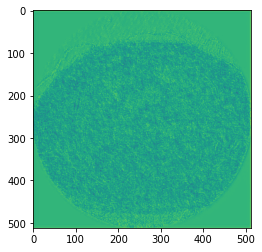

In [ ]:
test = masks_predict[51].reshape(512,512)

plt.imshow(test)
test.shape

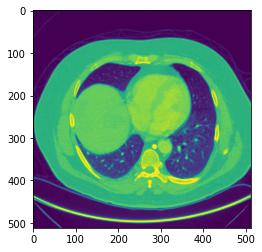

In [ ]:
imgs_mask_test_true = np.load(main_path+'testMasks.npy').astype(np.float32)
a = imgs_mask_test_true[14].reshape(512, 512)
plt.imshow(a)

False

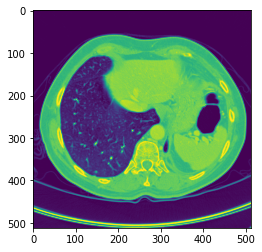

In [ ]:
b = imgs_mask_test_true[10].reshape(512, 512)
plt.imshow(b)
all_zeros = not np.any(b)
all_zeros

In [ ]:
imgs_mask_test_true.shape

(15, 1, 512, 512)

# create bounding box csv file

In [ ]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

In [ ]:
len_img = len(imgs_mask_test_true)
print (len_img)
imgs_mask_test_reshape = imgs_mask_test_true.reshape(len_img, 512, 512)

with open('gdrive/My Drive/luna/output_boundingbox.csv', mode='w') as out_file:
    csv_writer = csv.writer(out_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(['item', 'xmin', 'xmax', 'ymin', 'ymax'])
    line = 0
    for i in range(len_img):
        item = i
        #check if arrays contains all zero
        all_zeros = not np.any(imgs_mask_test_reshape[i])
        if all_zeros == False:
            b = bbox(imgs_mask_test_reshape[i])
            xmin = b[0]
            xmax = b[1]
            ymin = b[2]
            ymax = b[3]
        else:
            xmin = 0
            xmax = 0
            ymin = 0
            ymax = 0
        csv_writer.writerow([item, xmin, xmax, ymin, ymax])
        line += 1

15
